In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

os.makedirs('./results', exist_ok=True)

with open('./brown_100.txt', 'r') as file_:
    corpus = file_.read()

def write_freqs(list_: list, filename: str) -> None:
    with open(f'./results/{filename}.txt', 'w') as file_:
        file_.write('\n'.join([' '.join(x[0]) + ' | ' + str(x[1]) for x in list_]))

## N-Gram Language Modeling
In the second assignment, you will implement an **n-gram language model** that processes input text to generate, analyze, and calculate the probabilities of sequences of `n` words (n-grams). This model will tokenize text, create n-grams, and compute their frequencies and probabilities, returning the most frequent n-grams in the text.

1. **Tokenization**: Convert the input text into a list of words (tokens).
2. **N-gram Generation**: Create sequences of `n` tokens from the text, treating each sentence independently with the inclusion of start (`<s>`) and end (`</s>`) markers.
3. **Frequency Counting**: Count how many times each n-gram appears in the text.
4. **Probability Calculation**: Compute the probabilities of each n-gram based on its frequency and add alpha smoothing to improve generalization of items.
5. **Most Frequent N-grams**: Return the most frequent n-grams along with their probabilities, helping to identify common patterns in the text.

In [3]:
from collections import Counter, defaultdict # You may import more from collections if needed
from itertools import tee, islice
import re


class NGramModel:
    def __init__(self, text, n, alpha=0.0):
        """
        Initialize the NGramModel with text and the value of n.
        """
        self.text = text
        self.n = n
        self.alpha = alpha  # Alpha value for additive smoothing
        self.n_grams_list = []  # List to store n-grams
        self.ngrams = {}
        self.total_count = 0  # Total count of n-grams
        self.probabilities = {}
        self.vocab = set()

    def tokenize(self) -> None:
        """
        Tokenize the text into words. 
        Fill in the code to split the text into a list of words.
        """
        # Split sentences with inclusion of punctuation as tokens
        # '"' and word != '``' and word != "''" and word != '``']
        sentences = re.split(r'[.!?,"``'']', self.text)
        tokens = []
        # to tokenize each word in the sentences
        for sentence in sentences:
            sentence = sentence.strip()
            if sentence:
                token =['<s>']
                self.vocab.add('<s>')  # Add start token to vocabulary
                # Tokenize the sentence into words
                words = sentence.split()
                for word in words:
                 # Add them to the tokens list
                    token.append(word) 
                    self.vocab.add(word)  # Add to vocabulary          
            else:
                continue  
            token.append('</s>')
            self.vocab.add('</s>')  # Add end token to vocabulary
            tokens.append(token)  # Append the tokenized sentence to the tokens list
        return tokens

    def generate_ngrams(self, tokens: list) -> dict:
        """
        Generate n-grams from the list of tokens.
        Fill in the code to create n-grams.
        Make sure to treat each sentence independently, include the <s> and </s> tokens.
        """
        "Create sequences of `n` tokens from the text, treating each sentence independently with the inclusion of start (`<s>`) and end (`</s>`) markers."
        if self.n > 1:
            for sentence in tokens:  # each sentence is a list
                if len(sentence) >= self.n:
                    for j in range(len(sentence) - self.n+1):  
                        self.n_grams_list.append(tuple(sentence[j:j+self.n]))  # wrap single word as a tuple
        # if self.n == 1:
        #     for sentence in tokens:  # each sentence is a list
        #         if len(sentence) >= self.n:
        #             for j in range(len(sentence)- self.n+1):  # all words (not -1)
        #                 self.n_grams_list.append(tuple(sentence[j:j+1]))  # wrap single word as a tuple

        # elif self.n == 2:
        #     for sentence in tokens:  # each sentence is a list
        #         if len(sentence) >= self.n:
        #             for j in range(len(sentence)- self.n + 1):  
        #                 self.n_grams_list.append(tuple(sentence[j:j+2]))  # wrap single word as a tuple
            
        # elif self.n == 3:
        #     for sentence in tokens:  # each sentence is a list
        #         if len(sentence) >= self.n:
        #             for j in range(len(sentence) - self.n+1):  
        #                 self.n_grams_list.append(tuple(sentence[j:j+3]))  # wrap single word as a tuple
        else:
            # raise ValueError("n must be 1, 2, or 3 for unigrams, bigrams, or trigrams respectively.")
            raise ValueError("n must be greater than 1 for ngrams.")
        return self.n_grams_list


    def count_frequencies(self) -> None:
        """
        Count the frequencies of each n-gram.
        Fill in the code to count n-gram occurrences.
        """
        # Store the frequencies in the ngrams dictionary
        frequency_count = Counter()
        for member in self.n_grams_list:
            frequency_count[member] += 1
        self.ngrams = frequency_count
        self.total_count = sum(frequency_count.values())  
        
        return self.ngrams

        # raise NotImplementedError

    def calculate_probabilities(self) -> None:
        """
        Calculate probabilities of each n-gram based on its frequency. Add alpha smoothing separately.
        """
        if not self.ngrams:
            raise ValueError("Frequency of N-grams is not yet calculated.")

        V = len(self.vocab)  # Vocabulary size (for unigrams, you should also build vocab earlier)

        history_counts = Counter() # Count occurrences of histories (n-1 grams)
        for ngram, count in self.ngrams.items():
            history = ngram[:-1]
            history_counts[history] += count

        self.probabilities = {}

        for ngram, count in self.ngrams.items():
            history = ngram[:-1]
            history_count = history_counts[history]

            if self.alpha == 0:
                prob = count / history_count
            else:
                prob = (count + self.alpha) / (history_count + self.alpha * V)

            self.probabilities[ngram] = prob  # <-- Store each ngram's probability here

        return self.probabilities



    def most_frequent_ngrams(self, top_n: int = 10) -> list:
        """
        Return the most frequent n-grams and their probabilities.
        """
        # Sort the n-grams by frequency in descending order
        sorted_ngrams = sorted(self.ngrams.items(), key=lambda x: x[1], reverse=True)
        # Get the top n n-grams
        most_frequent = sorted_ngrams[:top_n]
        # Format the output as a list of tuples (n-gram, frequency, probability) for top n-grams
        most_frequent_ngrams = [(gram, self.probabilities[gram]) for gram, count in most_frequent]

        # to raise error if the n-grams are not calculated
        if not self.ngrams:
            raise ValueError(" Frequency of N-grams is not yet calculated.")
        
        return most_frequent_ngrams

# Testing the model with an example
text = "This is a simple example to demonstrate how n-grams work in this assignment. Looking at the example is faster than working with full n-grams corpus for the assignment." #Faster than running the full corpus
n = 2 # You can change this to 1, 2, or 3 for uni, bi, or trigrams
model = NGramModel(text, n)

tokens = model.tokenize()
print("Tokens:", tokens)
ngrams = model.generate_ngrams(tokens)
print("Generated n-grams:", ngrams)
model.count_frequencies()
print("N-gram frequencies:", model.ngrams)
model.calculate_probabilities()
print("N-gram probabilities:", model.probabilities)

# Print the most frequent n-grams
print(model.most_frequent_ngrams(10))


Tokens: [['<s>', 'This', 'is', 'a', 'simple', 'example', 'to', 'demonstrate', 'how', 'n-grams', 'work', 'in', 'this', 'assignment', '</s>'], ['<s>', 'Looking', 'at', 'the', 'example', 'is', 'faster', 'than', 'working', 'with', 'full', 'n-grams', 'corpus', 'for', 'the', 'assignment', '</s>']]
Generated n-grams: [('<s>', 'This'), ('This', 'is'), ('is', 'a'), ('a', 'simple'), ('simple', 'example'), ('example', 'to'), ('to', 'demonstrate'), ('demonstrate', 'how'), ('how', 'n-grams'), ('n-grams', 'work'), ('work', 'in'), ('in', 'this'), ('this', 'assignment'), ('assignment', '</s>'), ('<s>', 'Looking'), ('Looking', 'at'), ('at', 'the'), ('the', 'example'), ('example', 'is'), ('is', 'faster'), ('faster', 'than'), ('than', 'working'), ('working', 'with'), ('with', 'full'), ('full', 'n-grams'), ('n-grams', 'corpus'), ('corpus', 'for'), ('for', 'the'), ('the', 'assignment'), ('assignment', '</s>')]
N-gram frequencies: Counter({('assignment', '</s>'): 2, ('<s>', 'This'): 1, ('This', 'is'): 1, ('

### Unigrams

In this section, we apply the `NGramModel` to our corpus. The model can be configured to generate unigrams, bigrams, or trigrams by adjusting the value of `n`. After tokenizing the text and generating the n-grams, the model counts the occurrences of each n-gram and calculates their probabilities. The most frequent n-grams are then written to an output file.

By adjusting the n-gram size, we can analyze different levels of word dependencies in the text, providing insights into common word sequences and patterns.  

The code below will generate unigrams when the NGramModel is implemented correctly

In [ ]:
n = 1  # You can change this to 1, 2, or 3 for uni, bi, or trigrams
model = NGramModel(corpus, n)

tokens = model.tokenize()
ngrams = model.generate_ngrams(tokens)
model.count_frequencies()
model.calculate_probabilities()

write_freqs(model.most_frequent_ngrams(10), 'unigrams')
print("Most frequent unigrams:", model.most_frequent_ngrams(10))

Most frequent unigrams: [(('<s>',), 0.08272692454998085), (('</s>',), 0.08272692454998085), (('the',), 0.04902336269628495), ((',',), 0.0337035618536959), (('of',), 0.025660666411336654), (('to',), 0.02106472615855994), (('a',), 0.019149751053236307), (('and',), 0.015319800842589047), (('in',), 0.01493680582152432), (('``',), 0.013404825737265416)]


### Bigrams
Bigrams allow us to explore word pairs and their relationships, providing insight into common word combinations and phrase structures within the corpus.  
The code below will generate bigrams when the NGramModel is implemented correctly.

In [ ]:
n = 2  # You can change this to 1, 2, or 3 for uni, bi, or trigrams
model = NGramModel(corpus, n)

tokens = model.tokenize()
ngrams = model.generate_ngrams(tokens)
model.count_frequencies()
model.calculate_probabilities()

write_freqs(model.most_frequent_ngrams(10), 'bigrams')
print("Most frequent bigrams:", model.most_frequent_ngrams(10))

Most frequent bigrams: [(('</s>', '<s>'), 0.99), (('<s>', '</s>'), 0.41203703703703703), (('<s>', 'The'), 0.125), ((',', 'the'), 0.18181818181818182), (('in', 'the'), 0.38461538461538464), (("''", '</s>'), 0.4411764705882353), (('of', 'the'), 0.208955223880597), (('<s>', '``'), 0.037037037037037035), (("''", ','), 0.20588235294117646), (('the', 'jury'), 0.0546875)]


### Trigrams
Trigrams capture three-word sequences, providing a deeper understanding of longer word dependencies and commonly occurring phrases within the text.  
The code below will generate trigrams when the NGramModel is implemented correctly

In [ ]:
n = 3  # You can change this to 1, 2, or 3 for uni, bi, or trigrams
model = NGramModel(corpus, n)

tokens = model.tokenize()
ngrams = model.generate_ngrams(tokens)
model.count_frequencies()
model.calculate_probabilities()

write_freqs(model.most_frequent_ngrams(10), 'trigrams')
print("Most frequent trigrams:", model.most_frequent_ngrams(10))

Most frequent trigrams: [(('<s>', '</s>', '<s>'), 0.9887640449438202), (('</s>', '<s>', 'The'), 0.26262626262626265), (('</s>', '<s>', '``'), 0.08080808080808081), ((',', 'the', 'jury'), 0.4375), (('<s>', 'The', 'jury'), 0.2222222222222222), (("''", ',', 'the'), 0.8571428571428571), (('</s>', '<s>', 'It'), 0.06060606060606061), (('the', 'jury', 'said'), 0.7142857142857143), (('</s>', '<s>', 'A'), 0.04040404040404041), (('jury', 'said', ','), 0.42857142857142855)]


### Smoothing
Below, we generate **bigrams** with **smoothing** applied by setting `n = 2` and including a smoothing parameter `alpha = 1.0`. Smoothing is useful in language models to handle unseen n-grams by assigning a small probability to them. The model tokenizes the text, generates bigrams, counts their frequencies, and calculates smoothed probabilities. The most frequent bigrams are then written to an output file.





In [35]:
n = 2  # You can change this to 1, 2, or 3 for uni, bi, or trigrams
model = NGramModel(corpus, n, alpha=1.0)

tokens = model.tokenize()
ngrams = model.generate_ngrams(tokens)
model.count_frequencies()
model.calculate_probabilities()

write_freqs(model.most_frequent_ngrams(10), 'bigrams_smoothed')

### Generating Text
In this example, we generate text using the **bigrams** model by providing a starting **prompt** (e.g., "the jury"). The `generate_text` function creates a sequence of words based on the trained bigram model, starting from the provided prompt and continuing based on the probabilities of the next words.

After tokenizing the corpus, generating bigrams, and calculating their frequencies and probabilities, the model uses these learned probabilities to generate text. The generated output is then written to a file.

Text generation with n-grams helps illustrate how language models can predict word sequences, allowing us to create new sentences that follow similar patterns found in the original text.

In [ ]:
def generate_text(model: NGramModel, n: int, prompt: str) -> str:
    # Generate text based on the n-gram model and a given prompt.
    if n != model.n:
        raise ValueError(f"Model is built for n={model.n}, but n={n} was provided.")
    if not prompt:
        raise ValueError("Prompt is empty. Please provide a valid prompt.")
    generated_tokens = prompt.split()
    for i in range(15):
        if len(generated_tokens) < n-1:
            continue
        # Get the last n-1 tokens to form the context for prediction
        prev_tokens= tuple(generated_tokens[-(n-1):])
        # Get the probabilities of the next token given the previous n-1 tokens
        next_token_probs = {key_dictionary: prob_value_dictionary for key_dictionary, prob_value_dictionary in model.probabilities.items() if key_dictionary[:-1] == prev_tokens}
        if not next_token_probs:
            break  # No more tokens can be generated
        
        next_token = max(next_token_probs, key=next_token_probs.get)[-1]
        # Append the next token to the generated tokens
        if next_token == '</s>':
            break
        generated_tokens.append(next_token)
    
    return ' '.join(generated_tokens)
   
tokens = model.tokenize()
ngrams = model.generate_ngrams(tokens)
model.count_frequencies()
model.calculate_probabilities()
generated_text = generate_text(model, 2, 'the jury')
with open(f'./results/generated_bigrams.txt', 'w') as file_:
    file_.write(generated_text)

## Word Vectors
Based on the Stanford course: https://web.stanford.edu/class/cs224n/

### Count based W2V
In this section, we use the previously trained **n-gram model** to calculate a **co-occurrence matrix**. A co-occurrence matrix shows how often words appear together within a specific context (in this case, bigrams), providing insights into word relationships in the corpus.

Steps:
1. **Tokenization and N-gram Generation**: We first tokenize the text and generate bigrams using the `NGramModel`.
2. **Vocabulary and Indexing**: The vocabulary is created from the unique tokens, and a word-to-index mapping is established.
3. **Co-occurrence Matrix**: Using the generated n-grams, we compute the co-occurrence matrix, where each entry represents how often two words occur together within the bigrams.

The co-occurrence matrix provides a numerical representation of word relationships, which is useful for tasks like word embeddings, semantic analysis, and understanding word associations.

In [13]:
# Since we already have a working ngram model, for the next part we can use the ngrams to calculate the co-occurences.
model = NGramModel(corpus, 2)
tokens = model.tokenize()
ngrams = model.generate_ngrams(tokens)
# print("Generated n-grams:", ngrams)
# print("type of ngrams:", type(ngrams))
# print("length of ngrams:", len(ngrams))
# print("length of tokens:", len(tokens))
# print("length of tokens[0]:", len(tokens[0]))
# print("type of tokens:", type(tokens))
# print("type of tokens[0]:", type(tokens[0]))
# print("tokens[0]:", tokens[0])
# print("tokens[0][0]:", tokens[0][0])
# print("tokens:", tokens)

def create_co_matrix(ngrams: list, vocab_size: int, word_to_index: dict) -> np.ndarray:
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)
    for ngram in ngrams:
        for i in range(len(ngram)-1):
            word1 = ngram[i]
            word2 = ngram[i+1]
            if word1 in word_to_index and word2 in word_to_index:
                index1 = word_to_index[word1]
                index2 = word_to_index[word2]
                co_matrix[index1, index2] += 1
                co_matrix[index2, index1] += 1  # Symmetric matrix
    # # Normalize the co-occurrence matrix
    # co_matrix = co_matrix.astype(np.float32)
    # co_matrix /= np.sum(co_matrix, axis=1, keepdims=True)  # Normalize by row sums
    return co_matrix

# Given code
# vocab = list(set(tokens))
# Generative AI code soln
# vocab = list(list(tokens))
# for token in tokens:
#     vocab.extend(token)
# vocab = set(vocab)  # Remove duplicates
# vocab = list(vocab)  # Convert back to list

all_tokens = [token for sentence in tokens for token in sentence]
vocab = set(all_tokens)


vocab_size = len(vocab)
# print("vocab:", vocab)
print("vocab_size:", vocab_size)

# Create a word-to-index mapping
word_to_index = {word: idx for idx, word in enumerate(vocab)}

# Generate the co-occurrence matrix
co_matrix = create_co_matrix(ngrams, vocab_size, word_to_index)

# Optionally, print the matrix or parts of it
# print(co_matrix.value_counts())

vocab_size: 859


With the code below you can verify if the co-occurence works

In [14]:
def check_co_occurrence(word1, word2, co_matrix, word_to_index):
    """
    Print the co-occurrence count for a specific word pair.
    """
    if word1 not in word_to_index or word2 not in word_to_index:
        print(f"One or both words '{word1}' and '{word2}' are not in the vocabulary.")
        return

    index1 = word_to_index[word1]
    index2 = word_to_index[word2]

    co_count = co_matrix[index1][index2]
    print(f"Co-occurrence count for '{word1}' and '{word2}': {co_count}")

check_co_occurrence('the', 'jury', co_matrix, word_to_index)
check_co_occurrence('the', 'cat', co_matrix, word_to_index)

Co-occurrence count for 'the' and 'jury': 7
One or both words 'the' and 'cat' are not in the vocabulary.


In this part, we reduce the dimensionality of the **co-occurrence matrix** using **Singular Value Decomposition (SVD)**. This technique helps in extracting the most important features from the matrix, making it easier to visualize and interpret the relationships between words.

Steps:
1. **Singular Value Decomposition (SVD)**: The co-occurrence matrix is decomposed into three matrices: \( M = U \cdot \Sigma \cdot V^T \).
2. **Dimensionality Reduction**: We retain only the top `k` components (default is 2) from the SVD, effectively reducing the dimensionality of the matrix.
3. **Reduced Matrix**: The reduced matrix retains the most important semantic information and can be used for tasks such as **word embedding visualization** or **semantic similarity analysis**.

Dimensionality reduction allows us to capture the essence of word relationships in fewer dimensions, making it more efficient to process and visualize the data.

In [15]:
def reduce_to_k_dim(M, k=2):
    """
    Reduce the dimensionality of the co-occurrence matrix M to k dimensions using SVD.
    """
    U, S, Vt = np.linalg.svd(M, full_matrices=False)
    # print("U shape:", U.shape)
    # print("S shape:", S.shape)
    # print("Vt shape:", Vt.shape)
    # Select the top k singular values and corresponding vectors
    U_reduced = U[:, :k]
    S_reduced = np.diag(S[:k])
    Vt_reduced = Vt[:k, :]
    # Reconstruct the reduced matrix
    M_reduced = np.dot(U_reduced, S_reduced).dot(Vt_reduced)
    # # Normalize the reduced matrix
    # M_reduced = M_reduced.astype(np.float32)
    # M_reduced /= np.sum(M_reduced, axis=1, keepdims=True)  # Normalize by row sums

    return M_reduced

In this final part, we visualize the reduced word embeddings in **2D space**. After reducing the dimensionality of the co-occurrence matrix using SVD, we plot the embeddings for each word to observe their relationships in a low-dimensional space.

Steps:
1. **Plotting the Embeddings**: Each word from the vocabulary is plotted based on its 2D coordinates from the reduced matrix.
2. **Visualization**: The scatter plot allows us to see how words cluster together or relate to each other based on co-occurrences in the text. Words with similar contexts should appear closer to each other in the plot.
3. **Interpretation**: By looking at the 2D plot, we can analyze word similarities, relationships, and clusters formed by words that often occur together.

This visualization is a useful tool for understanding the structure of word embeddings and the relationships between words in the corpus.







plot embeddings fn type of word to index: <class 'dict'>
plot embeddings fn length of word_to_index: 859
word: has
word: story
word: of
word: in
word: state
word: jury


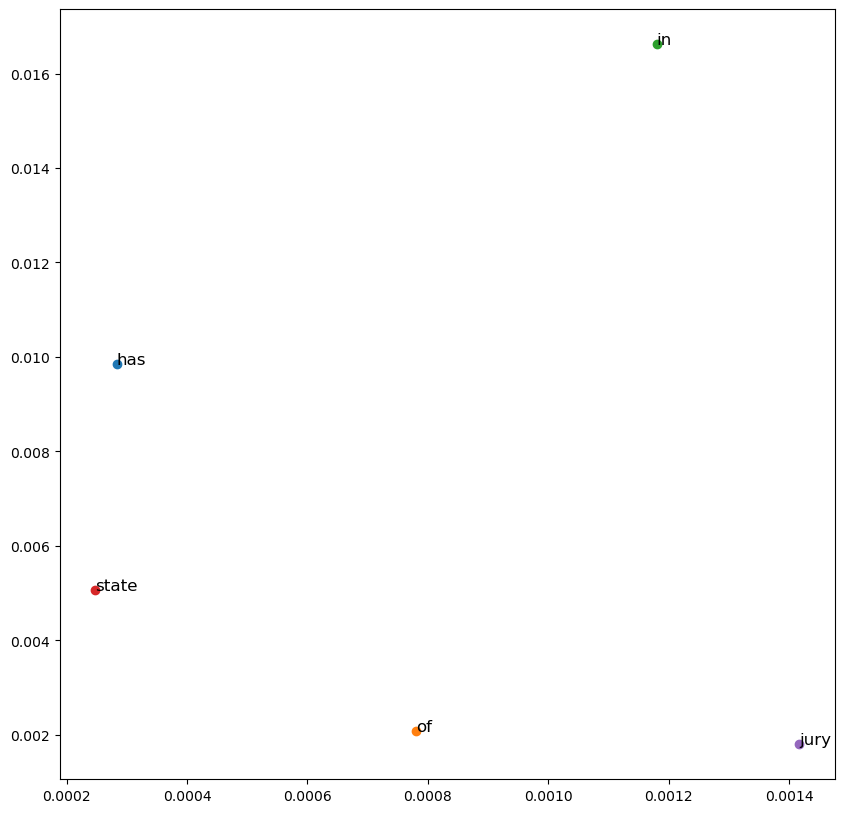

In [29]:
def plot_embeddings(M_reduced, words):
    """
    Plot the word embeddings in 2D space.
    """
    print("plot embeddings fn type of word to index:", type(word_to_index))
    print("plot embeddings fn length of word_to_index:", len(word_to_index))
    plt.figure(figsize=(10, 10))
    for i, word in enumerate(words):
        print("word:", word)
        if word in word_to_index:
            x, y = M_reduced[word_to_index[word], :2]
            plt.scatter(x, y)
            plt.annotate(word, (x, y), fontsize=12)

# words = ['take', 'story', 'of', 'also', 'under', 'state']
# words = ['has', 'story', 'of', 'said', 'in', 'state', 'jury']
words = ['has', 'story', 'of', 'in', 'state', 'jury']

M_reduced = reduce_to_k_dim(co_matrix, k=2)
# vocab_without_s = [word for word in vocab if word != '<s>' and word != '</s>' and word != '"' and word != '``' and word != "''"]
# # vocab_without_s = vocab.remove('<s>')
# # vocab_without_s = vocab.remove('</s>')
# plot_embeddings(M_reduced, vocab_without_s) 
# plt.savefig('./results/word_embeddings.png')  

plot_embeddings(M_reduced, words)

## Prediction-Based Word Vectors
In this section, we load pre-trained word vectors using the **GloVe** embeddings from the [Stanford NLP paper on GloVe](https://nlp.stanford.edu/pubs/glove.pdf). The pre-trained embeddings provide rich semantic information about words based on large text corpora, allowing us to represent words as vectors that capture their meaning and relationships.

Steps:
1. **Load GloVe Word Vectors**: We use the GloVe embeddings from the `glove-wiki-gigaword-200` model, which has 200-dimensional vectors for each word.
2. **Vocabulary Matching**: We map the words from our corpus to the GloVe vocabulary and extract the corresponding vectors.
3. **Dimensionality Reduction**: After obtaining the word vectors, we reduce the dimensionality to visualize the embeddings in 2D space, allowing us to explore word relationships visually.

This is an excellent opportunity to explore how pre-trained embeddings like GloVe can be used to improve downstream NLP tasks by providing richer word representations.

In [28]:
# Do not edit
import gensim.downloader as api
import numpy as np
wv_from_bin = api.load("glove-wiki-gigaword-200")
print("Loaded vocab size %i" % len(list(wv_from_bin.index_to_key)))

wv_words = list(wv_from_bin.index_to_key)
# unique_tokens = set(tokens)
all_tokens = [word for sentence in tokens for word in sentence]
unique_tokens = set(all_tokens)
word_to_index = {word: idx for idx, word in enumerate(unique_tokens)}
print("data type of unique_tokens:", type(unique_tokens))
print("data type of word_to_index:", type(word_to_index))
print("length of unique_tokens:", len(unique_tokens))
print("length of word_to_index:", len(word_to_index))
print("word_to_index:", word_to_index)
word2ind = {}
M = []
idx = 0
print('rendering M based on wv')
for w in wv_words:
    try:
        M.append(wv_from_bin.get_vector(w))
        word2ind[w] = idx
        idx += 1
    except:
        pass

print('rendering M based on unique_tokens')
for w in unique_tokens:
    if w in wv_words:
        continue
    try:
        M.append(wv_from_bin.get_vector(w))
        word2ind[w] = idx
        idx += 1
    except:
        pass
M = np.stack(M)
M_reduced = reduce_to_k_dim(M, k=2)

M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis]

Loaded vocab size 400000
data type of unique_tokens: <class 'set'>
data type of word_to_index: <class 'dict'>
length of unique_tokens: 859
length of word_to_index: 859
word_to_index: {'equitable': 0, 'out': 1, '13': 2, 'In': 3, 'expense': 4, 'must': 5, 'action': 6, 'Colquitt': 7, '$4': 8, 'administrators': 9, 'irregularities': 10, 'policies': 11, 'deputies': 12, 'something': 13, "Caldwell's": 14, 'granted': 15, 'jurors': 16, 'Felix': 17, 'with': 18, 'the': 19, 'farms': 20, 'being': 21, 'council': 22, 'commented': 23, 'taxpayers': 24, 'praised': 25, 'smell': 26, 'amendment': 27, 'There': 28, 'Opelika': 29, 'Roads': 30, 'expected': 31, 'next': 32, 'support': 33, 'Thursday': 34, 'further': 35, '2': 36, 'can': 37, 'Implementation': 38, 'study': 39, 'Dorsey': 40, 'Attorneys': 41, 'problem': 42, 'each': 43, 'Purchasing': 44, 'operating': 45, 'largest': 46, 'order': 47, 'City': 48, 'became': 49, 'got': 50, 'conducted': 51, 'violence': 52, 'couple': 53, 'compensation': 54, 'such': 55, 'elected

### Compare plots
What stands out when comparing the two different ways of embedding using the given words?

(Use this to help answer the question in your assignment document).

plot embeddings fn type of word to index: <class 'dict'>
plot embeddings fn length of word_to_index: 859
word: equitable
word: out
word: 13
word: In
word: expense
word: must
word: action
word: Colquitt
word: $4
word: administrators
word: irregularities
word: policies
word: deputies
word: something
word: Caldwell's
word: granted
word: jurors
word: Felix
word: with
word: the
word: farms
word: being
word: council
word: commented
word: taxpayers
word: praised
word: smell
word: amendment
word: There
word: Opelika
word: Roads
word: expected
word: next
word: support
word: Thursday
word: further
word: 2
word: can
word: Implementation
word: study
word: Dorsey
word: Attorneys
word: problem
word: each
word: Purchasing
word: operating
word: largest
word: order
word: City
word: became
word: got
word: conducted
word: violence
word: couple
word: compensation
word: such
word: elected
word: proportionate
word: didn't
word: Mac
word: Harry
word: 8
word: against
word: Jan
word: might
word: costs
word: st

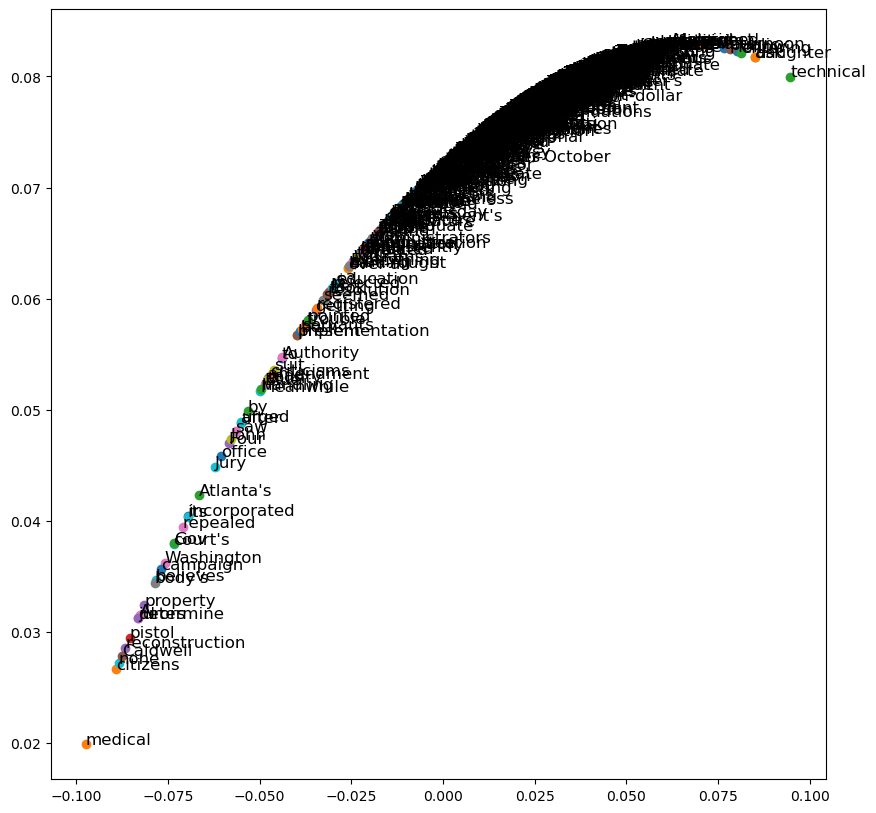

In [32]:
# plot_embeddings(M_reduced_normalized, tokens)
plot_embeddings(M_reduced_normalized, unique_tokens)
plt.savefig('./results/word_embeddings_glove.png')

### Words with multiple meanings
Polysemes and homonyms are words that have more than one meaning (see [this wiki page](https://en.wikipedia.org/wiki/Polysemy) to learn more about the difference between polysemes and homonyms). Your task is to find a word with at least two different meanings such that the top-10 most similar words (according to cosine similarity) contain related words from both meanings.

For example:
- "leaves" has both the "go_away" and "a_structure_of_a_plant" meanings in the top 10.
- "scoop" has both "handed_waffle_cone" and "lowdown" meanings in the top 10.

You will probably need to try several polysemous or homonymic words before you find one.

Once you discover a word that fits this criterion, state the word and explain the multiple meanings that occur in the top 10. Reflect on why many of the polysemous or homonymic words you tried didn’t work (i.e., why the top-10 most similar words only contain one of the word's meanings).

**Note**: Use the `wv_from_bin.most_similar(word)` function to get the top 10 most similar words. This function ranks all other words in the vocabulary based on their cosine similarity to the given word. For further assistance, you can refer to the [Gensim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html).

In [ ]:
## Your code here

### Synonyms
When considering **Cosine Similarity**, it's often useful to think of **Cosine Distance**, which is simply 1 - Cosine Similarity.

Find three words \( (w_1, w_2, w_3) \) where:
- \(w_1\) and \(w_2\) are **synonyms**.
- \(w_1\) and \(w_3\) are **antonyms**.

However, you need to find a case where **Cosine Distance** \( (w_1, w_3) < \text{Cosine Distance} (w_1, w_2) \). In other words, the antonym is **closer** to the word than its synonym in the vector space.

For example, "happy" (\(w_1\)) may be closer to "sad" (\(w_3\)) than to "cheerful" (\(w_2\)), which is counter-intuitive since we expect synonyms to be closer than antonyms. 

Once you find such an example, provide a possible explanation for why this result may have occurred.

Use the `wv_from_bin.distance(w1, w2)` function to compute the cosine distance between two words. You can refer to the [Gensim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html) for further assistance.







In [ ]:
## Your code here

### Analogies
Word vectors have demonstrated the ability to solve analogies based on their learned semantic relationships. For instance, consider the analogy: 

**"man : grandfather :: woman : x"** 

(Read: man is to grandfather as woman is to x). Using word vectors, we can find the word \(x\) that completes the analogy.

In the example provided, we use the `most_similar` function from the Gensim library. This function identifies words that are most similar to the words in the positive list and most dissimilar to those in the negative list. For analogy solving, it effectively computes:

\[ \text{word}(x) = \text{most similar to} (\text{woman} + \text{grandfather} - \text{man}) \]

The result is the word with the highest cosine similarity to the target vector. You can use this approach to explore various analogies and gain insights into the semantic structure of word vectors.

Refer to the [Gensim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html) for more details on the `most_similar` function and how word vectors handle analogy-solving tasks.

In [ ]:
# Run this cell to answer the analogy -- man : grandfather :: woman : x
print(wv_from_bin.most_similar(positive=['woman', 'grandfather'], negative=['man']))

[('grandmother', 0.7608445286750793), ('granddaughter', 0.7200808525085449), ('daughter', 0.7168302536010742), ('mother', 0.7151536345481873), ('niece', 0.7005682587623596), ('father', 0.6659887433052063), ('aunt', 0.6623408794403076), ('grandson', 0.6618767976760864), ('grandparents', 0.644661009311676), ('wife', 0.6445354223251343)]


### Bias in word vectors
a. **Observation**: Consider the results of a word vector model when queried with analogies involving "man", "woman", and "profession". What are the top results returned by the model for each query?

[Your Answer]

b. **Analysis**: Do you observe any gender biases in the results? For example, are certain professions more closely associated with "man" or "woman" based on the word vectors? Discuss how word embeddings might perpetuate societal biases present in the training data.

[Your Answer]

c. **Reflection**: How might such biases affect the fairness of machine learning models that use word embeddings? Suggest potential strategies for mitigating gender bias in word vector models.

[Your Answer]

In [33]:
print(wv_from_bin.most_similar(positive=['man', 'profession'], negative=['woman']))
print()
print(wv_from_bin.most_similar(positive=['woman', 'profession'], negative=['man']))

[('reputation', 0.5250176787376404), ('professions', 0.5178037881851196), ('skill', 0.49046966433525085), ('skills', 0.49005505442619324), ('ethic', 0.4897659420967102), ('business', 0.487585186958313), ('respected', 0.4859202802181244), ('practice', 0.482104629278183), ('regarded', 0.4778572916984558), ('life', 0.4760662019252777)]

[('professions', 0.5957457423210144), ('practitioner', 0.4988412857055664), ('teaching', 0.48292139172554016), ('nursing', 0.48211804032325745), ('vocation', 0.4788965880870819), ('teacher', 0.47160351276397705), ('practicing', 0.46937811374664307), ('educator', 0.46524322032928467), ('physicians', 0.46289944648742676), ('professionals', 0.4601393938064575)]
